# Smart Traffic Control System using DIP
## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.filters.rank import median
import enum

## Convert colored images to grayscale using luminosity method
<b>grayscale value = 0.3R + 0.59G + 0.11B</b>

In [3]:
def convert_to_grayscale(img):
    new_img = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = (img[i][j][0]*0.3) + (img[i][j][1]*0.59) + (img[i][j][2]*0.1)
            new_img[i][j] = int(new_img[i][j]) #ensure non-float type
                
    return new_img;


## Generic thresholding function

In [4]:
def threshold(img, th):
    result = np.zeros(img.shape, dtype= np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = img[i][j]
            if val > th:
                result[i][j] = 255; #thresholding outputs binary image
    return result


## Focus only on regions of interest in the image

In [5]:
def img_and(img,operand):
    new_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if operand[i][j] != 0: #any non-zero value counts as HIGH when ANDing
                new_img[i][j] = img[i][j]
    return new_img

def remove_disturbance(img):
    logical_operand = io.imread('assets/logical_operand.png')
    logical_operand = convert_to_grayscale(logical_operand)
    return img_and(img,logical_operand)


## Preprocess Image

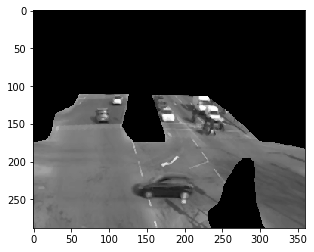

In [6]:
frame1 = io.imread('assets/frame1.png')
frame2 = io.imread('assets/frame2.png')


frame1_gray = convert_to_grayscale(frame1);
frame2_gray = convert_to_grayscale(frame2);


frame1_smooth = median(frame1_gray, np.ones((3,3))/9)
frame2_smooth = median(frame2_gray, np.ones((3,3))/9)


frame1_focussed = remove_disturbance(frame1_smooth)
frame2_focussed = remove_disturbance(frame2_smooth)


plt.imshow(frame1_focussed, 'gray')


## Use differentiation with respect to time to find moving components

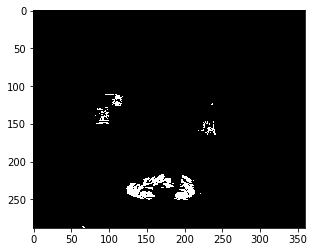

In [10]:
def frame_difference(f1,f2):
    result = np.zeros(f1.shape, dtype=np.uint8)
    for i in range(f1.shape[0]):
        for j in range(f2.shape[1]):
            new_val = abs(int(f2[i][j]) - int(f1[i][j])) #change uint8 to int and allow -ve values
            result[i][j] = new_val;
    return result


frame1_focussed = remove_disturbance(frame1_focussed)
frame2_focussed = remove_disturbance(frame2_focussed)


moving_objects = frame_difference(frame1_focussed, frame2_focussed)
moving_objects = threshold(moving_objects, 10)

plt.imshow(moving_objects, 'gray')



# Extract all foreground components

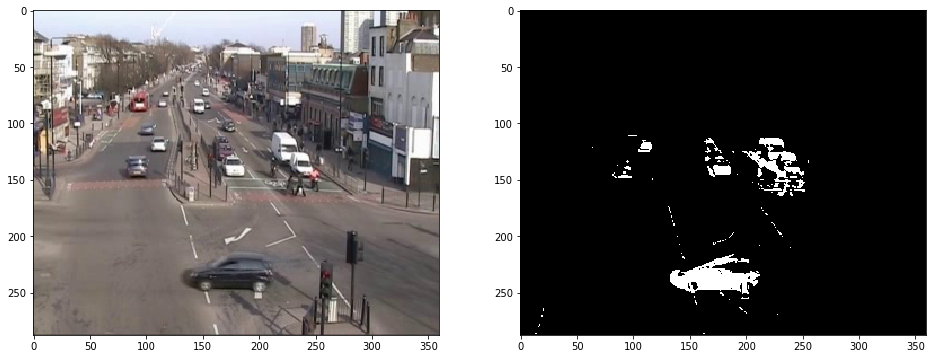

In [11]:
background = io.imread('assets/background.png')
background = convert_to_grayscale(background)
background = remove_disturbance(background)

def extract_foreground(img,background_img):
    result = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i][j] = abs(int(img[i][j]) - int(background_img[i][j]))
    return result

foreground = extract_foreground(frame1_focussed,background)
foreground = threshold(foreground,50)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)
ax1.imshow(frame1 ,cmap=plt.cm.gray)
ax2.imshow(foreground ,cmap=plt.cm.gray)


plt.show()



# Region Seperation

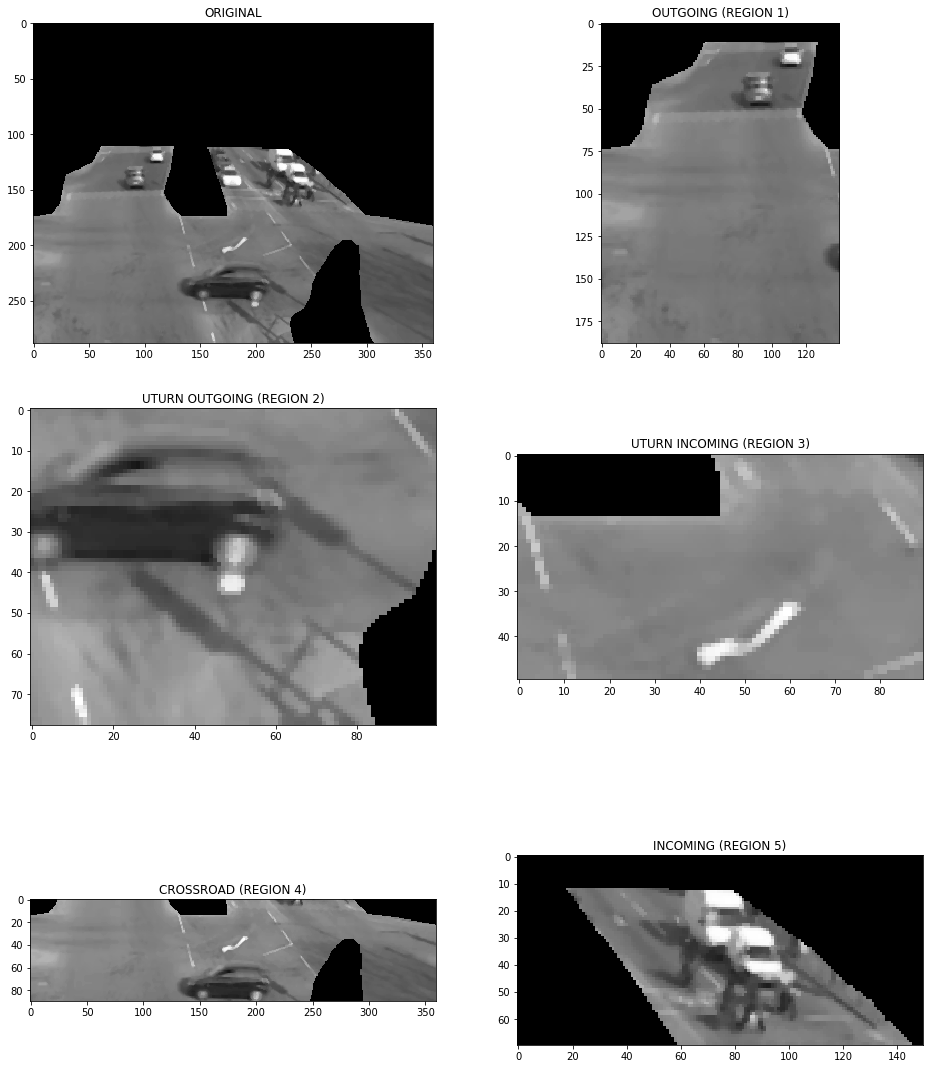

In [15]:
def crop_first_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[100:,0:140])
    return cropped_imgs

def crop_second_region(imgs):
    cropped_imgs = []
    for img in imgs:
         cropped_imgs.append(img[210:,150:250])
    return cropped_imgs

def crop_third_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:210,130:220])
    return cropped_imgs

def crop_fourth_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:250,:])
    return cropped_imgs

def crop_fifth_region(imgs):
    region5_operand = io.imread('assets/region5_operand.png')
    region5_operand = convert_to_grayscale(region5_operand)
    cropped_imgs = []
    for img in imgs:
        new_img= img_and( img,region5_operand)[100:170,150:300]
        cropped_imgs.append(new_img)
    return cropped_imgs



[region1] = crop_first_region([frame1_focussed])
[region2] = crop_second_region([frame1_focussed])
[region3] = crop_third_region([frame1_focussed])
[region4] = crop_fourth_region([frame1_focussed])
[region5] = crop_fifth_region([frame1_focussed])


fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2)
fig.set_size_inches(16,20)
ax1.imshow(frame1_focussed, 'gray')
ax2.imshow(region1, 'gray')
ax3.imshow(region2, 'gray')
ax4.imshow(region3, 'gray')
ax5.imshow(region4, 'gray')
ax6.imshow(region5, 'gray')

ax1.set_title("ORIGINAL")
ax2.set_title("OUTGOING (REGION 1)")
ax3.set_title("UTURN OUTGOING (REGION 2)")
ax4.set_title("UTURN INCOMING (REGION 3)")
ax5.set_title("CROSSROAD (REGION 4)")
ax6.set_title("INCOMING (REGION 5)")


plt.show()


## Traffic Finite State Machine


- State 1: <b>INCOMING</b> and <b>OUTGOING</b> roads can be green simultaneously, but no other road can be green
<br>
- State 2: Once moving cars in <b>INCOMING</b> and <b>OUTGOING</b> are <i>LOW</i> they will turn red
<br>
- State 2: If <b>UTURN</b> stopped cars are <i>HIGH</i> then both will be green and will remain green until moving cars are low
<br>
- State 3: Then, only <b>CROSSROAD</b> will turn green and will remain green until moving cars are <i>LOW</i>, then it will return to State 1
<br>
<br>

## Conditions
- <i>Before any traffic light turns red, it will turn yellow first for 3 seconds to prevent sudden unexpected stops.</i>
<br>
- <i>If one car is present in any red lit region, it can wait for a maximum of 30 seconds.</i>
<br>

## Limitations
- Traffic video cannot be directly used for testing since cars will not respond to feedback from the model
- Each region has a different size, meaning that 1 car in each region will have a different average value in each one, but this is worked-around by using different decision boundary values for each region

## Finite State Machine Diagram

![image](assets/fsm_diagram.png)

## Generic function to get the average value of an image

In [16]:
def img_get_avg(region):
    val_sum = 0;
    for i in range(region.shape[0]):
        for j in range(region.shape[1]):
            val_sum += region[i][j]
    return val_sum / (region.shape[0] * region.shape[1])


## Testing the model
### Assume state 3

In [17]:




[region1_moving, region1_foreground] = crop_first_region([moving_objects,foreground])
[region2_moving, region2_foreground] = crop_second_region([moving_objects,foreground])
[region3_moving, region3_foreground] = crop_third_region([moving_objects,foreground])
[region4_moving, region4_foreground] = crop_fourth_region([moving_objects,foreground])
[region5_moving, region5_foreground] = crop_fifth_region([moving_objects,foreground])






Text(0.5, 1.0, 'region5 Foreground')

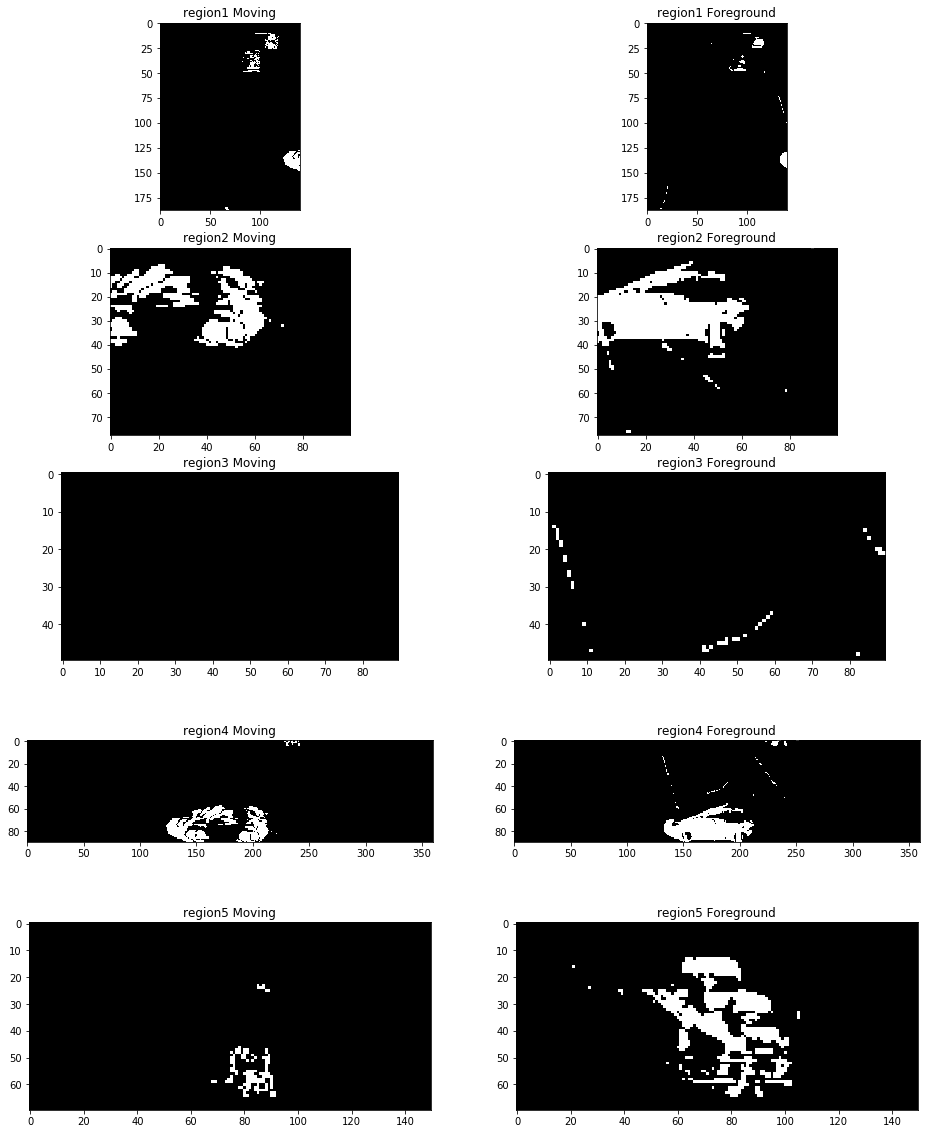

In [18]:
fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2)
fig.set_size_inches(16,20)

#Region 1
ax1.imshow(region1_moving, 'gray')
ax2.imshow(region1_foreground, 'gray')

#Region 2
ax3.imshow(region2_moving, 'gray')
ax4.imshow(region2_foreground, 'gray')

#Region 3
ax5.imshow(region3_moving, 'gray')
ax6.imshow(region3_foreground, 'gray')

#Region 4
ax7.imshow(region4_moving, 'gray')
ax8.imshow(region4_foreground, 'gray')

#Region 5
ax9.imshow(region5_moving, 'gray')
ax10.imshow(region5_foreground, 'gray')

ax1.set_title("region1 Moving")
ax2.set_title("region1 Foreground")

ax3.set_title("region2 Moving")
ax4.set_title("region2 Foreground")

ax5.set_title("region3 Moving")
ax6.set_title("region3 Foreground")

ax7.set_title("region4 Moving")
ax8.set_title("region4 Foreground")

ax9.set_title("region5 Moving")
ax10.set_title("region5 Foreground")


OUTGOING MOVING: 5
OUTGOING STOPPED: -2

OUTGOING UTURN MOVING: 29
OUTGOING UTURN STOPPED: 10

INCOMING UTURN MOVING: 0
INCOMING UTURN STOPPED: 2

CROSSROAD MOVING: 10
CROSSROAD STOPPED: 1

INCOMING MOVING: 3
INCOMING STOPPED: 19



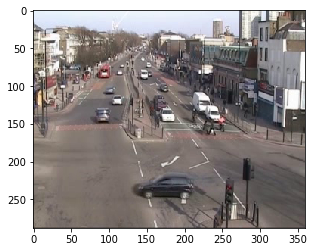

In [19]:
r1_moving_score = img_get_avg(region1_moving)
r1_stopped_score = img_get_avg(region1_foreground) - r1_moving_score #subtraction because foreground includes moving cars

r2_moving_score = img_get_avg(region2_moving)
r2_stopped_score = img_get_avg(region2_foreground) - r2_moving_score

r3_moving_score = img_get_avg(region3_moving)
r3_stopped_score = img_get_avg(region3_foreground) - r3_moving_score

r4_moving_score = img_get_avg(region4_moving)
r4_stopped_score = img_get_avg(region4_foreground) - r4_moving_score

r5_moving_score = img_get_avg(region5_moving)
r5_stopped_score = img_get_avg(region5_foreground) - r5_moving_score

plt.imshow(frame1)


print("OUTGOING MOVING: %d" % r1_moving_score)
print("OUTGOING STOPPED: %d\n" % r1_stopped_score)

print("OUTGOING UTURN MOVING: %d" % r2_moving_score)
print("OUTGOING UTURN STOPPED: %d\n" % r2_stopped_score)

print("INCOMING UTURN MOVING: %d" % r3_moving_score)
print("INCOMING UTURN STOPPED: %d\n" % r3_stopped_score)

print("CROSSROAD MOVING: %d" % r4_moving_score)
print("CROSSROAD STOPPED: %d\n" % r4_stopped_score)

print("INCOMING MOVING: %d" % r5_moving_score)
print("INCOMING STOPPED: %d\n" % r5_stopped_score)

# Observations
- Outgoing region of interest had a stopped score of <0 and a small moving score, conforms with the traffic snapshot used
- Outgoing Uturn recorded a high score even though no cars are in the outgoing uturn. However, the car moving in crossroad is passing through the outgoing uturn region, therefore in finding a decision, Uturn score during state3 is unusable
- Crossroad moving has a non-zero scorec

# Creating the module for this junction
### INPUTS: current frame - previous frame - background image - current state
### OUTPUTS: best next state

In [20]:

class State(enum.Enum):
    state1 = 1
    state2 = 2
    state3 = 3
    
@jit          
def preprocess_image(
    img1, 
    img2,
    region5_operand,
    logical_operand,
    background_img
):
    
    current_frame = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
    prev_frame = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
    frame_diff = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8) # moving components image
    background_sub = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8) # all components image
    
    region1_cnt=0    # used for averaging images
    region1_mov=0
    region1_all=0
    
    region2_cnt=0    
    region2_mov=0
    region2_all=0
    
    region3_cnt=0    
    region3_mov=0
    region3_all=0
    
    region4_cnt=0    
    region4_mov=0
    region4_all=0
    
    region5_cnt=0    
    region5_mov=0
    region5_all=0
    
 

    
    for i in range(img1.shape[0]):
        region1_all_width=0
        region1_mov_width=0    
        region2_all_width=0
        region2_mov_width=0   
        region3_all_width=0
        region3_mov_width=0   
        region4_all_width=0
        region4_mov_width=0   
        region5_all_width=0
        region5_mov_width=0   
        for j in range(img1.shape[1]):
            # [logical_operand] is read as rgb image,
            if logical_operand[i][j][0] != 0 or logical_operand[i][j][1] != 0 or logical_operand[i][j][2] != 0:
                
                # get grayscale values for background, current frame, and previous frame
                background_val = (background_img[i][j][0]*0.3) + (background_img[i][j][1]*0.59) + (background_img[i][j][2]*0.1)
                
                current_frame[i][j] = (img1[i][j][0]*0.3) + (img1[i][j][1]*0.59) + (img1[i][j][2]*0.1)
                current_frame[i][j] = int(current_frame[i][j]) 
                
                prev_frame[i][j] = (img2[i][j][0]*0.3) + (img2[i][j][1]*0.59) + (img2[i][j][2]*0.1)
                prev_frame[i][j] = int(prev_frame[i][j]) 
                
                
                
                frame_diff_temp = abs(int(current_frame[i][j]) - int(prev_frame[i][j]))
                if frame_diff_temp > 10: #thresholding
                    frame_diff[i][j] = 255
                
                background_sub_temp = abs(int(current_frame[i][j]) - int(background_val))
                if background_sub_temp > 50: #thresholding
                    background_sub[i][j] = 255
                    
                #image average calculation
                if i > 100 and j < 140: #region1
#                     region1_mov += frame_diff[i][j];
#                     region1_all += background_sub[i][j];
                    
                    region1_mov_width += frame_diff[i][j];
                    region1_all_width += background_sub[i][j];  
                    
                    region1_cnt += 1;
                if i > 210 and j > 150 and j < 250: #region2
#                     region2_mov += frame_diff[i][j];    
#                     region2_all += background_sub[i][j];
                    
                    region2_mov_width += frame_diff[i][j];
                    region2_all_width += background_sub[i][j];  
                    
                    region2_cnt += 1;
                if i > 160 and i < 210 and j > 130 and j < 220: #region3
#                     region3_mov += frame_diff[i][j];         
#                     region3_all += background_sub[i][j];
                    
                    region3_mov_width += frame_diff[i][j];
                    region3_all_width += background_sub[i][j];
                    
                    region3_cnt += 1;
                if i > 160 and i < 250: #region4
#                     region4_mov += frame_diff[i][j];   
#                     region4_all += background_sub[i][j];
                    
                    region4_mov_width += frame_diff[i][j];
                    region4_all_width += background_sub[i][j];  
                    
                    region4_cnt += 1;
                if region5_operand[i][j][0] != 0 or region5_operand[i][j][1] != 0 or region5_operand[i][j][2] != 0: #region5
#                     region5_mov += frame_diff[i][j];
#                     region5_all += background_sub[i][j];
                    
                    region5_mov_width += frame_diff[i][j];
                    region5_all_width += background_sub[i][j];  
                    
                    region5_cnt += 1;
        region1_mov += width_distance_factor(height_distance_factor(region1_mov_width,i),i)
        region1_all += width_distance_factor(height_distance_factor(region1_all_width,i),i)
        region2_mov += width_distance_factor(height_distance_factor(region2_mov_width,i),i)
        region2_all += width_distance_factor(height_distance_factor(region2_all_width,i),i)
        region3_mov += width_distance_factor(height_distance_factor(region3_mov_width,i),i)
        region3_all += width_distance_factor(height_distance_factor(region3_all_width,i),i)
        region4_mov += width_distance_factor(height_distance_factor(region4_mov_width,i),i)
        region4_all += width_distance_factor(height_distance_factor(region4_all_width,i),i)
        region5_mov += region5_factoring(region5_mov_width,1)
        region5_all += region5_factoring(region5_all_width,1)


    return [
        [region1_mov/157500, region1_all/157500],
        [region2_mov/157500, region2_all/157500],
        [region3_mov/157500, region3_all/157500],
        [region4_mov/315000, region4_all/315000],
        [region5_mov/129000, region5_all/49060]
    ]

@jit          
def width_distance_factor(car_width, vertical_position):
    return car_width + ((252.2 - vertical_position) / 5.435)
@jit          
def height_distance_factor(car_width, vertical_position):
    return car_width + ((252.2 - vertical_position) / 3.88)
@jit          
def region5_factoring(car_width, vertical_position):
    first_result = car_width + ((vertical_position - 143.5) / 5.435)
    return car_width + ((vertical_position - 143.5) / 3.88)

def get_all_scores(regions):
    scores = {}
    for i in range(len(regions)):
        scores[f'r{i+1}_move'] = regions[i][0]
        scores[f'r{i+1}_stop'] = regions[i][1] - scores[f'r{i+1}_move']
    return scores


def handle_first_state_output(scores):
    if scores['r1_move'] + scores['r5_move'] > 5:
        return State.state1
    else:
        if scores['r2_stop'] + scores['r3_stop'] > 1:
            return State.state2
        else:
            return State.state3

    
def handle_second_state_output(scores):
    if scores['r2_move'] + scores['r3_move'] > 2:
        return State.state2
    else:
        return State.state3
        
def handle_third_state_output(scores):
    if scores['r4_move'] < 3:
        return State.state1
    else:
        return State.state3
        
    
# Images are input as paths                                   
def get_next_state(current_frame_path, previous_frame_path, current_state, region5_operand,logical_operand,background_img):
    current_frame = io.imread(current_frame_path)
    previous_frame = io.imread(previous_frame_path)

    regions_data = preprocess_image(current_frame, previous_frame, region5_operand,logical_operand,background_img)
    scores = get_all_scores(regions_data)
    
    
    # Handle output according to the current state
    next_state = None
    if current_state == State.state1:
        next_state = handle_first_state_output(scores)
    elif current_state == State.state2:
        next_state = handle_second_state_output(scores)
    elif current_state == State.state3:
        next_state = handle_third_state_output(scores)
    
                                   
    return [next_state,scores] 

 

# Validation
### By testing all possible scenarios

case 1:
Next State -> state1
region 1 moving: 5.008928571428571
region 1 stopped: -2.112082066869301
region 2 moving: 29.03076923076923
region 2 stopped: 7.2903846153846175
region 3 moving: 0.0
region 3 stopped: 0.6233333333333333
region 4 moving: 10.239351851851852
region 4 stopped: 1.1097222222222225
region 5 moving: 3.0357142857142856
region 5 stopped: 19.744285714285716


case 2:
Next State -> state1
region 1 moving: 34.48119300911854
region 1 stopped: -0.4553571428571459
region 2 moving: 22.39423076923077
region 2 stopped: 46.815384615384616
region 3 moving: 11.446666666666667
region 3 stopped: 34.56666666666667
region 4 moving: 26.71990740740741
region 4 stopped: 6.12314814814815
region 5 moving: 25.402857142857144
region 5 stopped: -0.8742857142857154


case 3:
Next State -> state3
region 1 moving: 2.6740121580547114
region 1 stopped: -2.024886018237082
region 2 moving: 0.0
region 2 stopped: 0.06538461538461539
region 3 moving: 0.0
region 3 stopped: 0.056666666666666664
region 4

Text(0.5, 1.0, 'case 7\noutput=state2')

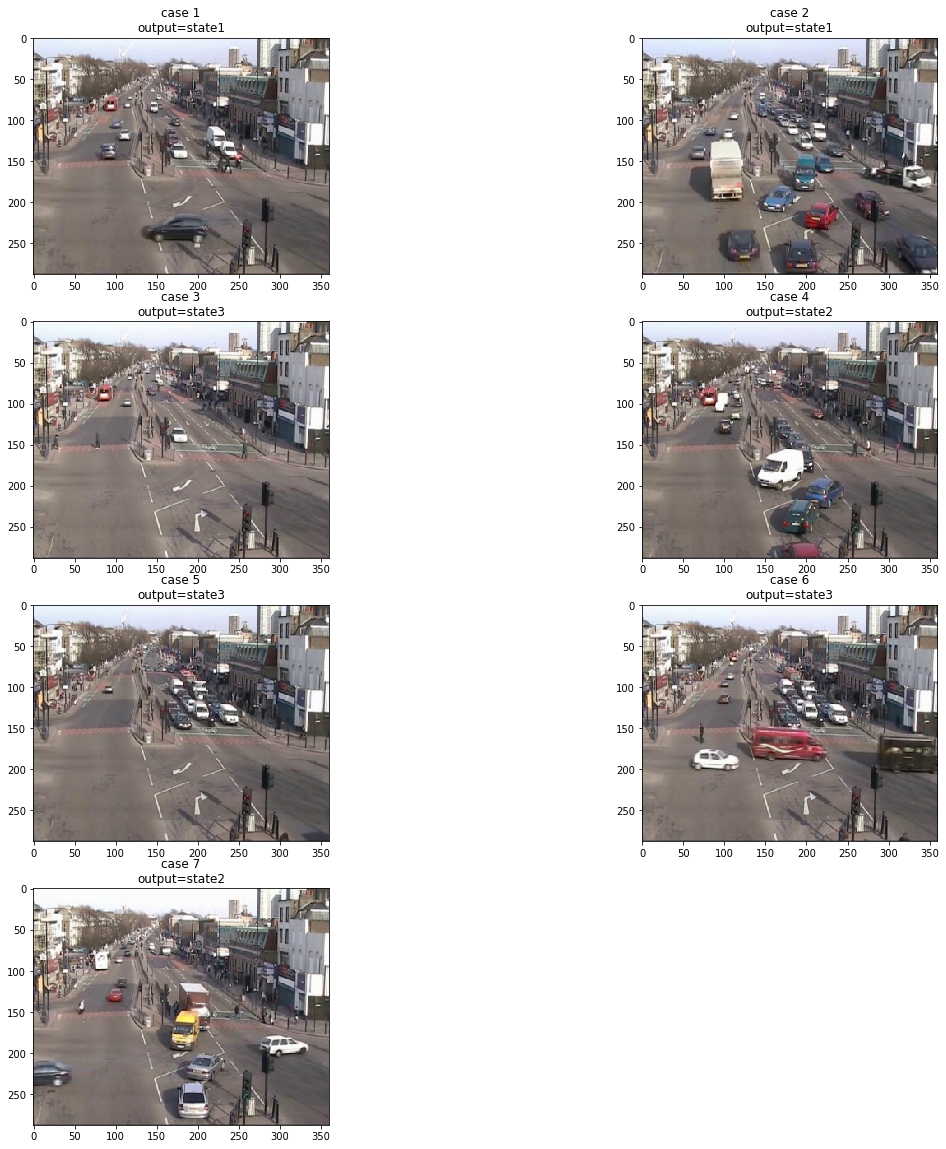

In [21]:
def print_scores(scores):
    for key in scores.keys():
        suffix = None
        if(key[3:5] == 'mo'):
            suffix = 'moving'
        else:
            suffix = 'stopped'
        print(f'region {key[1]} {suffix}: {scores[key]}')
    print('\n')
    
region5_operand = io.imread('assets/region5_operand.png')
logical_operand = io.imread('assets/logical_operand.png')
background_img = io.imread('assets/background.png')

case1_frames = ['assets/frame1.png','assets/frame2.png']
case2_frames = ['assets/frame3.png','assets/frame4.png']
case3_frames = ['assets/frame5.png','assets/frame6.png']
case5_frames = ['assets/frame9.png','assets/frame10.png']
case4_frames = ['assets/frame7_2.png','assets/frame8_2.png']
case6_frames = ['assets/frame11.png','assets/frame12.png']
case7_frames = ['assets/frame13.png','assets/frame14.png']
case8_frames = ['assets/frame15.png','assets/frame16.png']
case9_frames = ['assets/frame17.png','assets/frame18.png']
case10_frames = ['assets/frame19.png','assets/frame20.png']

start = timeit.default_timer()
case1 = get_next_state(case1_frames[0], case1_frames[1], State.state3, region5_operand,logical_operand,background_img)
print("case 1:")
print("Next State -> " + case1[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case1[1])



start = timeit.default_timer()
case2 = get_next_state(case2_frames[0], case2_frames[1], State.state1, region5_operand,logical_operand,background_img)
print("case 2:")
print("Next State -> " + case2[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  

print_scores(case2[1])

start = timeit.default_timer()
case3 = get_next_state(case3_frames[0], case3_frames[1], State.state2, region5_operand,logical_operand,background_img)
print("case 3:")
print("Next State -> " + case3[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case3[1])

start = timeit.default_timer()
case4 = get_next_state(case4_frames[0], case4_frames[1], State.state1, region5_operand,logical_operand,background_img)
print("case 4:")
print("Next State -> " + case4[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case4[1])

start = timeit.default_timer()
case5 = get_next_state(case5_frames[0], case5_frames[1], State.state1, region5_operand,logical_operand,background_img)
print("case 5:")
print("Next State -> " + case5[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case5[1])

start = timeit.default_timer()
case6 = get_next_state(case6_frames[0], case6_frames[1], State.state3, region5_operand,logical_operand,background_img)
print("case 6:")
print("Next State -> " + case6[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case6[1])

start = timeit.default_timer()
case7 = get_next_state(case7_frames[0], case7_frames[1], State.state2, region5_operand,logical_operand,background_img)
print("case 7:")
print("Next State -> " + case7[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case7[1])

start = timeit.default_timer()
case8 = get_next_state(case8_frames[0], case8_frames[1], State.state3, region5_operand,logical_operand,background_img)
print("case 8:")
print("Next State -> " + case8[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case8[1])

start = timeit.default_timer()
case9 = get_next_state(case9_frames[0], case9_frames[1], State.state3, region5_operand,logical_operand,background_img)
print("case 9:")
print("Next State -> " + case9[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case9[1])

start = timeit.default_timer()
case10 = get_next_state(case10_frames[0], case10_frames[1], State.state3, region5_operand,logical_operand,background_img)
print("case 10:")
print("Next State -> " + case10[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case10[1])

'''
fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2)
fig.set_size_inches(20,20)
fig.delaxes(ax8)
ax1.imshow(io.imread(case1_frames[0]), 'gray')
ax2.imshow(io.imread(case2_frames[0]), 'gray')
ax3.imshow(io.imread(case3_frames[0]), 'gray')
ax4.imshow(io.imread(case4_frames[0]), 'gray')
ax5.imshow(io.imread(case5_frames[0]), 'gray')
ax6.imshow(io.imread(case6_frames[0]), 'gray')
ax7.imshow(io.imread(case7_frames[0]), 'gray')


ax1.set_title("case 1\n" + f"output={case1[0].name}") #from state3 to state1
ax2.set_title("case 2\n" + f"output={case2[0].name}") #from state1 to state1
ax3.set_title("case 3\n" + f"output={case3[0].name}") #from state2 to state3
ax4.set_title("case 4\n" + f"output={case4[0].name}") #from state1 to state2 
ax5.set_title("case 5\n" + f"output={case5[0].name}") #from state1 to state3
ax6.set_title("case 6\n" + f"output={case6[0].name}") #from state3 to state3
ax7.set_title("case 7\n" + f"output={case7[0].name}") #from state2 to state2 
'''


## All results conform with the logic of the state machine and observations from the images

In [ ]:
###DATASET 2
class State(enum.Enum):
    state1 = 1
    state2 = 2
    state3 = 3

@jit
def preprocess_image(
    img1, 
    img2,
    logical_operand,
    background_img,
    region1_operand,
    region3_operand
):
    
    current_frame = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
    prev_frame = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
    frame_diff = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8) # moving components image
    background_sub = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8) # all components image
    test_img = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8) # all components image

    # used for averaging images
    region1_mov=0
    region1_all=0
    
    region2_mov=0
    region2_all=0
    
    region3_mov=0
    region3_all=0
    
    region4_mov=0
    region4_all=0
     

    for i in range(img1.shape[0]):


        
        region1_all_width=0
        region1_mov_width=0   
        
        region2_all_width=0
        region2_mov_width=0   
        
        region3_all_width=0
        region3_mov_width=0   
        
        region4_all_width=0
        region4_mov_width=0   
  
        for j in range(img1.shape[1]):
            # [logical_operand] is read as rgb image,
            if logical_operand[i][j][0] != 0 or logical_operand[i][j][1] != 0 or logical_operand[i][j][2] != 0:
                
                # get grayscale values for background, current frame, and previous frame
                background_val = (background_img[i][j][0]*0.3) + (background_img[i][j][1]*0.59) + (background_img[i][j][2]*0.1)
                
                current_frame[i][j] = (img1[i][j][0]*0.3) + (img1[i][j][1]*0.59) + (img1[i][j][2]*0.1)
                current_frame[i][j] = int(current_frame[i][j]) 
                
                prev_frame[i][j] = (img2[i][j][0]*0.3) + (img2[i][j][1]*0.59) + (img2[i][j][2]*0.1)
                prev_frame[i][j] = int(prev_frame[i][j]) 
                
                
                
                frame_diff_temp = abs(int(current_frame[i][j]) - int(prev_frame[i][j]))

                if frame_diff_temp > 75 and frame_diff_temp < 255: #thresholding
                    frame_diff[i][j] = 255
                
                background_sub_temp = abs(int(current_frame[i][j]) - int(background_val))
                test_img[i][j] = abs(int(current_frame[i][j]) - int(background_val))
                if background_sub_temp > 120: #thresholding
                    background_sub[i][j] = 255
                
                #image average calculation
                if region1_operand[i][j][0] != 0 or region1_operand[i][j][1] != 0 or region1_operand[i][j][2] != 0: #region1
                    region1_mov_width += frame_diff[i][j];
                    region1_all_width += background_sub[i][j];  
                if i > 300 and i <500 and j<200: #region2
                    region2_mov_width += frame_diff[i][j];
                    region2_all_width += background_sub[i][j];
                if region3_operand[i][j][0] != 0 or region3_operand[i][j][1] != 0 or region3_operand[i][j][2] != 0: #region3              
                    region3_mov_width += frame_diff[i][j];
                    region3_all_width += background_sub[i][j];       
                if i > 300 and i <500 and j>300: #region4
                    region4_mov_width += frame_diff[i][j];
                    region4_all_width += background_sub[i][j];


#         region1_mov += region1_mov_width
#         region1_all += region1_all_width
        
        region2_mov += region2_mov_width
        region2_all += region2_all_width
        
#         region3_mov += region3_mov_width
#         region3_all += region3_all_width
        
#         region4_mov += region4_mov_width
#         region4_all += region4_all_width

        region1_mov += distance_factoring(region1_mov_width,i)
        region1_all += distance_factoring(region1_all_width,i)
        
#         region2_mov += distance_factoring(region2_mov_width,i)
#         region2_all += distance_factoring(region2_all_width,i)
        
        region3_mov += distance_factoring(region3_mov_width,i)
        region3_all += distance_factoring(region3_all_width,i)
        
        region4_mov += distance_factoring(region4_mov_width,i)
        region4_all += distance_factoring(region4_all_width,i)
        
    return [
        [region1_mov/180000, region1_all/200000000],
        [region2_mov/280000, region2_all/280000],
        [region3_mov/150000, region3_all/150000],
        [region4_mov/500000, region4_all/500000]
    ]

@jit
def distance_factoring(car_width, vertical_position):
    first_result = abs(car_width - abs((vertical_position - 262.5) * 32))
    return first_result - abs((vertical_position - 262.5) * 32)

def get_all_scores(regions):
    scores = {}
    for i in range(len(regions)):
        scores[f'r{i+1}_move'] = regions[i][0]
        scores[f'r{i+1}_stop'] = regions[i][1] - abs(scores[f'r{i+1}_move'])
    return scores


def handle_first_state_output(scores):
    if scores['r1_move'] + scores['r3_move'] > 5:
        return State.state1
    else:
        if scores['r2_move'] > 0:
            return State.state3
        else:
            return State.state1

        
def handle_third_state_output(scores):
    if scores['r4_move'] < 3:
        return State.state1
    else:
        return State.state3
        
    
# Images are input as paths  
def get_next_state(current_frame_path, 
                   previous_frame_path, 
                   current_state,
                   region1_operand, 
                   region3_operand,
                   logical_operand,
                   background_img):
    current_frame = io.imread(current_frame_path)
    previous_frame = io.imread(previous_frame_path)
          
    regions_data = preprocess_image(
        current_frame,
        previous_frame,
        logical_operand,
        background_img,
        region1_operand,
        region3_operand
    )
    scores = get_all_scores(regions_data)
    
    
    # Handle output according to the current state
    next_state = None
    if current_state == State.state1:
        next_state = handle_first_state_output(scores)
    elif current_state == State.state3:
        next_state = handle_third_state_output(scores)
    
                                   
    return [next_state,scores] 

 

In [ ]:
def print_scores(scores):
    for key in scores.keys():
        suffix = None
        if(key[3:5] == 'mo'):
            suffix = 'moving'
        else:
            suffix = 'stopped'
        print(f'region {key[1]} {suffix}: {scores[key]}')
    print('\n')

region1_operand = io.imread('assets/dataset2/region1_operand.png')
region3_operand = io.imread('assets/dataset2/region3_operand.png')
logical_operand = io.imread('assets/dataset2/logical_operand.png')
background_img = io.imread('assets/dataset2/background.png')

case1_frames = ['assets/dataset2/frame1.png','assets/dataset2/frame2.png']
case2_frames = ['assets/dataset2/frame3.png','assets/dataset2/frame4.png']
case3_frames = ['assets/dataset2/frame5.png','assets/dataset2/frame6.png']
case4_frames = ['assets/dataset2/frame7.png','assets/dataset2/frame8.png']
case5_frames = ['assets/dataset2/frame9.png','assets/dataset2/frame10.png']
case6_frames = ['assets/dataset2/frame11.png','assets/dataset2/frame12.png']
case7_frames = ['assets/dataset2/frame13.png','assets/dataset2/frame14.png']
case8_frames = ['assets/dataset2/frame15.png','assets/dataset2/frame16.png']
case9_frames = ['assets/dataset2/frame17.png','assets/dataset2/frame18.png']
case10_frames = ['assets/dataset2/frame19.png','assets/dataset2/frame20.png']
case11_frames = ['assets/dataset2/frame21.png','assets/dataset2/frame22.png']


start = timeit.default_timer()
case1 = get_next_state(case1_frames[0], case1_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 1:")
print("Next State -> " + case1[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case1[1])



start = timeit.default_timer()
case2 = get_next_state(case2_frames[0], case2_frames[1], State.state1, region1_operand,region3_operand,logical_operand,background_img)
print("case 2:")
print("Next State -> " + case2[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  

print_scores(case2[1])

start = timeit.default_timer()
case3 = get_next_state(case3_frames[0], case3_frames[1], State.state1, region1_operand,region3_operand,logical_operand,background_img)
print("case 3:")
print("Next State -> " + case3[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case3[1])

start = timeit.default_timer()
case4 = get_next_state(case4_frames[0], case4_frames[1], State.state1, region1_operand,region3_operand,logical_operand,background_img)
print("case 4:")
print("Next State -> " + case4[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case4[1])

start = timeit.default_timer()
case5 = get_next_state(case5_frames[0], case5_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 5:")
print("Next State -> " + case5[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case5[1])

start = timeit.default_timer()
case6 = get_next_state(case6_frames[0], case6_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 6:")
print("Next State -> " + case6[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case6[1])

start = timeit.default_timer()
case7 = get_next_state(case7_frames[0], case7_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 7:")
print("Next State -> " + case7[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case7[1])

start = timeit.default_timer()
case8 = get_next_state(case8_frames[0], case8_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 8:")
print("Next State -> " + case8[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case8[1])

start = timeit.default_timer()
case9 = get_next_state(case9_frames[0], case9_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 9:")
print("Next State -> " + case9[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case9[1])

start = timeit.default_timer()
case10 = get_next_state(case10_frames[0], case10_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 10:")
print("Next State -> " + case10[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case10[1])

start = timeit.default_timer()
case11 = get_next_state(case11_frames[0], case11_frames[1], State.state3, region1_operand,region3_operand,logical_operand,background_img)
print("case 11:")
print("Next State -> " + case11[0].name)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print_scores(case11[1])



fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6) , (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2)
fig.set_size_inches(60,100)
ax1.imshow(io.imread(case1_frames[0]), 'gray')
ax2.imshow(io.imread(case2_frames[0]), 'gray')
ax3.imshow(io.imread(case3_frames[0]), 'gray')
ax4.imshow(io.imread(case4_frames[0]), 'gray')
ax5.imshow(io.imread(case5_frames[0]), 'gray')
ax6.imshow(io.imread(case6_frames[0]), 'gray')
ax7.imshow(io.imread(case7_frames[0]), 'gray')
ax8.imshow(io.imread(case8_frames[0]), 'gray')
ax9.imshow(io.imread(case9_frames[0]), 'gray')
ax10.imshow(io.imread(case10_frames[0]), 'gray')



ax1.set_title("case 1\n" + f"output={case1[0].name}") #
ax2.set_title("case 2\n" + f"output={case2[0].name}") #
ax3.set_title("case 3\n" + f"output={case3[0].name}") #
ax4.set_title("case 4\n" + f"output={case4[0].name}") # 
ax5.set_title("case 5\n" + f"output={case5[0].name}") #
ax6.set_title("case 6\n" + f"output={case6[0].name}") #
ax7.set_title("case 7\n" + f"output={case7[0].name}") #
ax8.set_title("case 8\n" + f"output={case8[0].name}") # 
ax9.set_title("case 9\n" + f"output={case9[0].name}") #
ax10.set_title("case 10\n" + f"output={case10[0].name}") # 
